In [95]:
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [96]:
# set number of assets (= number of qubits)
num_assets = 8

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

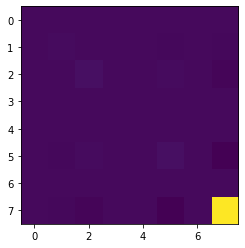

In [97]:
# plot sigma
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [98]:
q = 0.5                   # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

In [99]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [100]:
%%time
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result = exact_eigensolver.run()

print_result(result)

Optimal: selection [0 0 1 0 1 1 1 0], value -0.0153

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1 1 1 0]	-0.0153		1.0000
[1 1 1 1 1 1 1 1]	128.5048		0.0000
[1 1 1 1 0 0 1 0]	8.0039		0.0000
[0 0 1 1 1 0 1 0]	-0.0138		0.0000
[1 1 0 1 1 0 1 0]	8.0136		0.0000
[0 1 0 1 1 0 1 0]	0.0107		0.0000
[1 0 0 1 1 0 1 0]	-0.0013		0.0000
[0 0 0 1 1 0 1 0]	7.9960		0.0000
[1 1 1 0 1 0 1 0]	8.0009		0.0000
[0 1 1 0 1 0 1 0]	-0.0021		0.0000
[1 0 1 0 1 0 1 0]	-0.0128		0.0000
[0 0 1 0 1 0 1 0]	7.9845		0.0000
[1 1 0 0 1 0 1 0]	0.0123		0.0000
[0 1 0 0 1 0 1 0]	8.0093		0.0000
[1 0 0 0 1 0 1 0]	7.9973		0.0000
[0 0 0 0 1 0 1 0]	31.9946		0.0000
[0 1 1 1 0 0 1 0]	0.0009		0.0000
[0 1 1 1 1 0 1 0]	7.9996		0.0000
[1 0 1 1 0 0 1 0]	-0.0098		0.0000
[0 0 1 1 0 0 1 0]	7.9874		0.0000
[1 1 0 1 0 0 1 0]	0.0147		0.0000
[0 1 0 1 0 0 1 0]	8.0117		0.0000
[1 0 0 1 0 0 1 0]	7.9998		0.0000
[0 0 0 1 0 0 1 0]	31.9970		0.0000
[1 1 1 0 0 0

In [101]:
backend = Aer.get_backend('qasm_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)

Optimal: selection [1 0 1 1 1 0 0 0], value -0.0070


AttributeError: 'Counts' object has no attribute 'to_matrix'

In [102]:
backend = Aer.get_backend('qasm_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)

Optimal: selection [0 0 1 1 0 0 1 0], value 7.9874


AttributeError: 'Counts' object has no attribute 'to_matrix'